# AML Challenge 2 Baseline Solution

This notebook is almost based on the Github [respository](https://github.com/daisukelab/dcase2020_task2_variants). 

We replicate the (Variational Auto-Encoder) VAE method for this AML challenge 2 which is a small scale of the official DCASE challenge [task 2](https://dcase.community/challenge2020/task-unsupervised-detection-of-anomalous-sounds). 

# Required Python Packages

Let's install some python packages used in this notebook.

In [5]:
!pip install torchsummary
!pip install dl-cliche

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 80.6 MB/s eta 0:00:00:00:0100:01


In [83]:
!pip install aquarel 

To import our own functions, you could upload the .py files in the input folder and do as we do for the "common.py" and "pytorch_common.py" files.

In [6]:
from shutil import copyfile
#copyfile(src = "../input/model123/model.py", dst = "../working/model.py")

# copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "../input/dcase2020-task2-baseline/pytorch_common.py", dst = "../working/pytorch_common.py")
copyfile(src = "../input/dcase2020-task2-baseline/common.py", dst = "../working/common.py")

# import all our functions
import common as com
import pytorch_common
from pytorch_common import *

# public modules
import torch
import torch.nn.functional as F
import torchsummary
import pytorch_lightning as pl
import random
import common as com
import librosa
import os
import glob
import csv
import re
import itertools
import sys
import path
import numpy
import seaborn as sns
from scipy import signal
from torch import nn
from tqdm import tqdm
from sklearn import metrics
from dlcliche.utils import *
from dlcliche.notebook import *
from dlcliche.utils import (
    sys, random, Path, np, plt, EasyDict,
    ensure_folder, deterministic_everything,
)


# Data Exploration

How many samples included?

How are the raw wave files?

How are the log mel spectrogram of the wave files?

Machine types: ['slider']


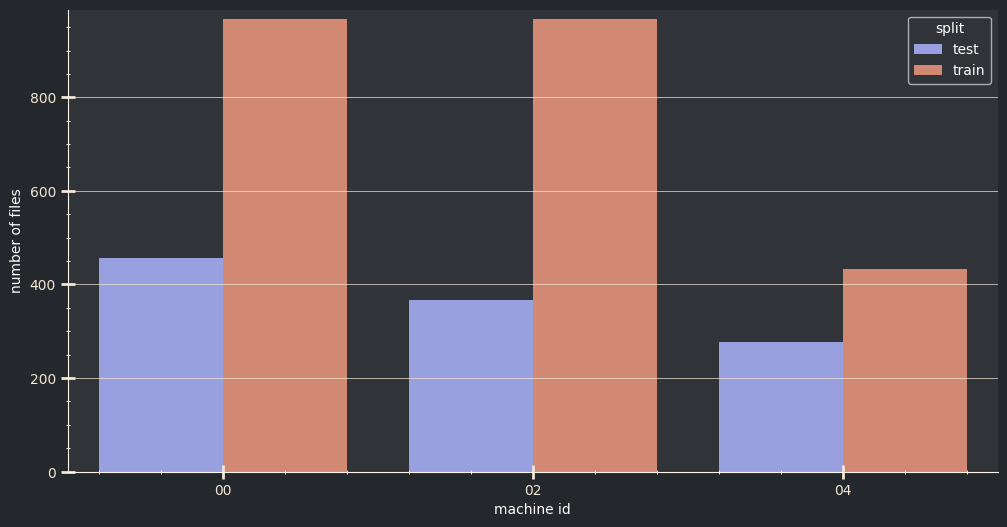

id      00         02         04      
split test train test train test train
file   456   968  367   968  278   434
type   456   968  367   968  278   434

In [122]:
load_theme("umbra_dark").apply()
# development dataset
DATA_ROOT=Path("../input/eurecom-aml-2022-challenge-2/dev_data/dev_data")
types = [t.name for t in sorted(DATA_ROOT.glob('*')) if t.is_dir()]
print('Machine types:', types)

df = pd.DataFrame()
df['file'] = sorted(DATA_ROOT.glob('*/*/*.wav'))
df['type'] = df.file.map(lambda f: f.parent.parent.name)
df['split'] = df.file.map(lambda f: f.parent.name)
df['id'] = df.file.map(lambda s: str(s).split('/')[-1].split('_')[-2])

agg = df.groupby(['id', 'split']).agg('count')
fig = plt.figure(figsize=(12.0, 6.0))
g = sns.barplot(x="id", y="file", hue="split", data=agg.reset_index())
plt.xlabel("machine id")
plt.ylabel("number of files")
plt.show()
agg.transpose()

In [8]:
df.groupby(['type', 'split']).describe()

file                                                            \
             count unique                                                top   
type   split                                                                   
slider test   1101   1101  ../input/eurecom-aml-2022-challenge-2/dev_data...   
       train  2370   2370  ../input/eurecom-aml-2022-challenge-2/dev_data...   

                     id                  
             freq count unique top freq  
type   split                             
slider test     1  1101      3  00  456  
       train    1  2370      3  00  968

In [9]:
df.shape

(3471, 4)

Machine types: ['slider']


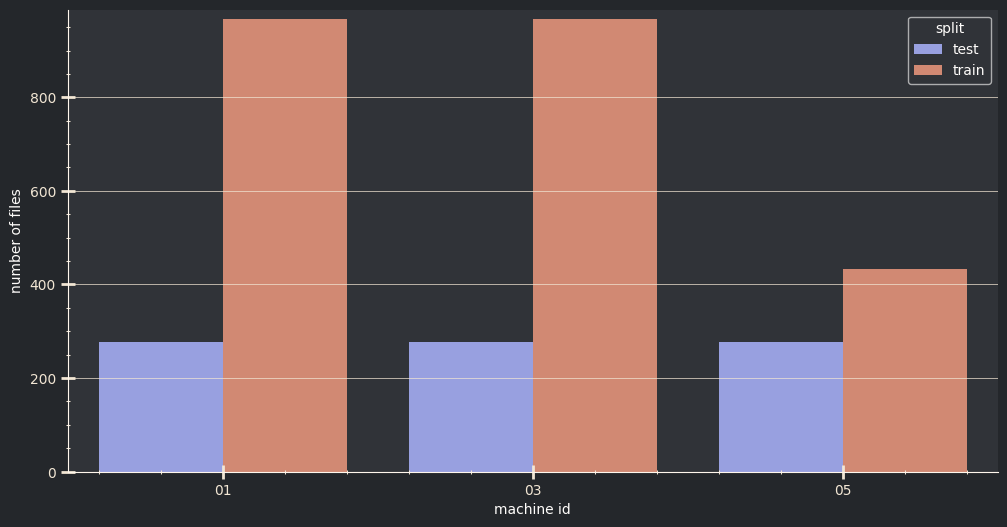

id      01         03         05      
split test train test train test train
file   278   968  278   968  278   434
type   278   968  278   968  278   434

In [121]:
load_theme("umbra_dark").apply()
# evaluation dataset
DATA_ROOT=Path("../input/eurecom-aml-2022-challenge-2/eval_data/eval_data")
types = [t.name for t in sorted(DATA_ROOT.glob('*')) if t.is_dir()]
print('Machine types:', types)

df_eval = pd.DataFrame()
df_eval['file'] = sorted(DATA_ROOT.glob('*/*/*.wav'))
df_eval['type'] = df_eval.file.map(lambda f: f.parent.parent.name)
df_eval['split'] = df_eval.file.map(lambda f: f.parent.name)
df_eval['id'] = df_eval.file.map(lambda s: str(s).split('/')[-1].split('_')[-2])

agg = df_eval.groupby(['id', 'split']).agg('count')
fig = plt.figure(figsize=(12.0, 6.0))
g = sns.barplot(x="id", y="file", hue="split", data=agg.reset_index())
plt.xlabel("machine id")
plt.ylabel("number of files")
plt.show()
agg.transpose()

In [16]:
df.groupby(['type', 'split']).describe()

file                                                            \
             count unique                                                top   
type   split                                                                   
slider test   1101   1101  ../input/eurecom-aml-2022-challenge-2/dev_data...   
       train  2370   2370  ../input/eurecom-aml-2022-challenge-2/dev_data...   

                     id                  
             freq count unique top freq  
type   split                             
slider test     1  1101      3  00  456  
       train    1  2370      3  00  968

In [11]:
df_eval.groupby(['type', 'split']).describe()

file                                                            \
             count unique                                                top   
type   split                                                                   
slider test    834    834  ../input/eurecom-aml-2022-challenge-2/eval_dat...   
       train  2370   2370  ../input/eurecom-aml-2022-challenge-2/eval_dat...   

                     id                  
             freq count unique top freq  
type   split                             
slider test     1   834      3  01  278  
       train    1  2370      3  01  968

In [18]:
#load a normal sound 
import soundfile as sf
normal_signal_file = df.file.iloc[1]
normal_signal, samplerate = sf.read(normal_signal_file)
print(f'The signals have a {normal_signal.shape} shape. At {samplerate} Hz, these are {normal_signal.shape[0]/samplerate:.0f}s signals')

The signals have a (160000,) shape. At 16000 Hz, these are 10s signals


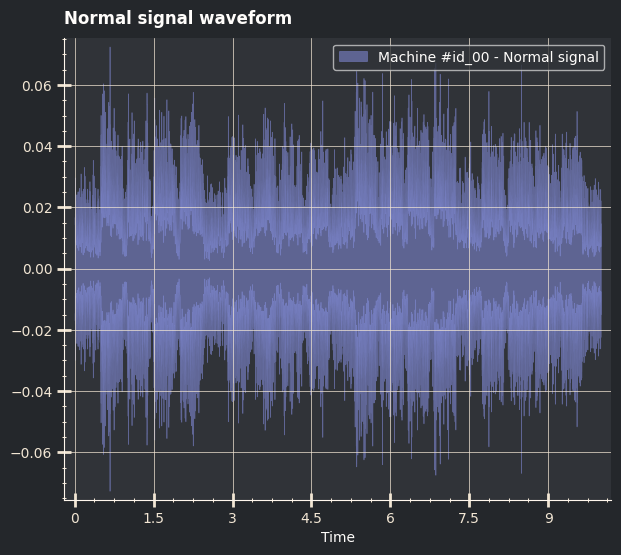

In [120]:
load_theme("umbra_dark").apply()
#display the waveform of a normal sound
import librosa.display
fig = plt.figure(figsize=(24, 6))
plt.subplot(1,3,1)
librosa.display.waveshow(normal_signal, sr=samplerate, alpha=0.5, linewidth=0.5, label='Machine #id_00 - Normal signal')
plt.title('Normal signal waveform')
plt.legend();

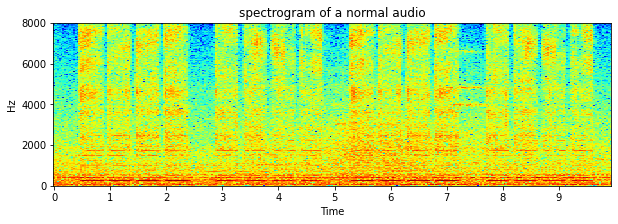

In [50]:
# plot the spectrogram
n_fft=1024
hop_length=512
fig, ax = plt.subplots(figsize=(10, 3))
S_normal = np.abs(librosa.stft(
    normal_signal, n_fft=n_fft, hop_length=hop_length, center=False))
librosa.display.specshow(
    librosa.amplitude_to_db(S_normal, ref=np.max), n_fft=n_fft, 
    hop_length=hop_length, sr=samplerate, x_axis='time', y_axis='linear',
    ax=ax, cmap='jet')
ax.set(title='spectrogram of a normal audio');

In [52]:
#load an anomaly sound
anomaly_signal_file = df.file.iloc[1]
anomaly_signal, samplerate = sf.read(anomaly_signal_file)
print(f'The signals have a {anomaly_signal.shape} shape. At {samplerate} Hz, these are {anomaly_signal.shape[0]/samplerate:.0f}s signals')

The signals have a (160000,) shape. At 16000 Hz, these are 10s signals


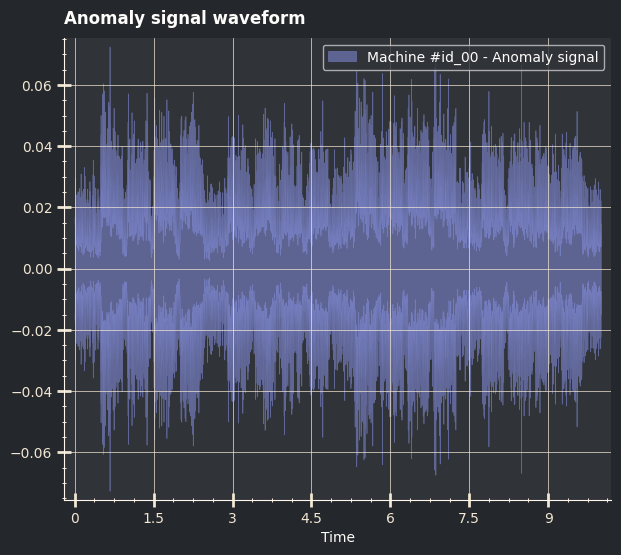

In [119]:
load_theme("umbra_dark").apply()

import librosa.display
fig = plt.figure(figsize=(24, 6))
plt.subplot(1,3,1)
librosa.display.waveshow(anomaly_signal, sr=samplerate, alpha=0.5, linewidth=0.5, label='Machine #id_00 - Anomaly signal')
plt.title('Anomaly signal waveform')
plt.legend();

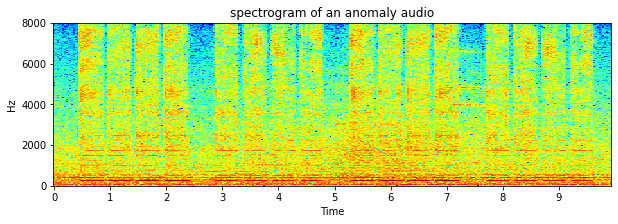

In [54]:
# plot the spectrogram
n_fft=1024
hop_length=512
fig, ax = plt.subplots(figsize=(10, 3))
S_anomaly = np.abs(librosa.stft(
    anomaly_signal, n_fft=n_fft, hop_length=hop_length, center=False))
librosa.display.specshow(
    librosa.amplitude_to_db(S_anomaly, ref=np.max), n_fft=n_fft, 
    hop_length=hop_length, sr=samplerate, x_axis='time', y_axis='linear',
    ax=ax, cmap='jet')
ax.set(title='spectrogram of an anomaly audio');

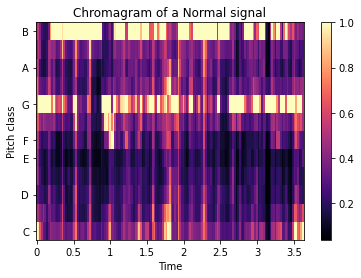

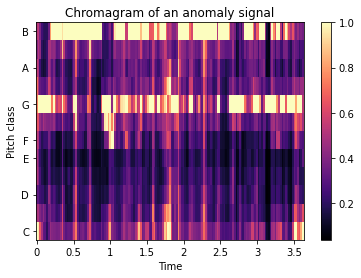

In [55]:
S = np.abs(librosa.stft(normal_signal))
chroma = librosa.feature.chroma_stft(S=S, sr=samplerate)
S = np.abs(librosa.stft(normal_signal, n_fft=4096))**2
chroma = librosa.feature.chroma_stft(S=S, sr=samplerate)
fig, ax = plt.subplots()
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='Chromagram of a Normal signal')
plt.show()

S = np.abs(librosa.stft(anomaly_signal))
chroma = librosa.feature.chroma_stft(S=S, sr=samplerate)
S = np.abs(librosa.stft(anomaly_signal, n_fft=4096))**2
chroma = librosa.feature.chroma_stft(S=S, sr=samplerate)
fig, ax = plt.subplots()
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='Chromagram of an anomaly signal')
plt.show()

In [57]:
def file_load(wav_name, mono=False):
    try:
        return librosa.load(wav_name, sr=None, mono=mono)
    except:
        print("file_broken or not exists!! : {}".format(wav_name))

=== Machine type [slider], train set ===


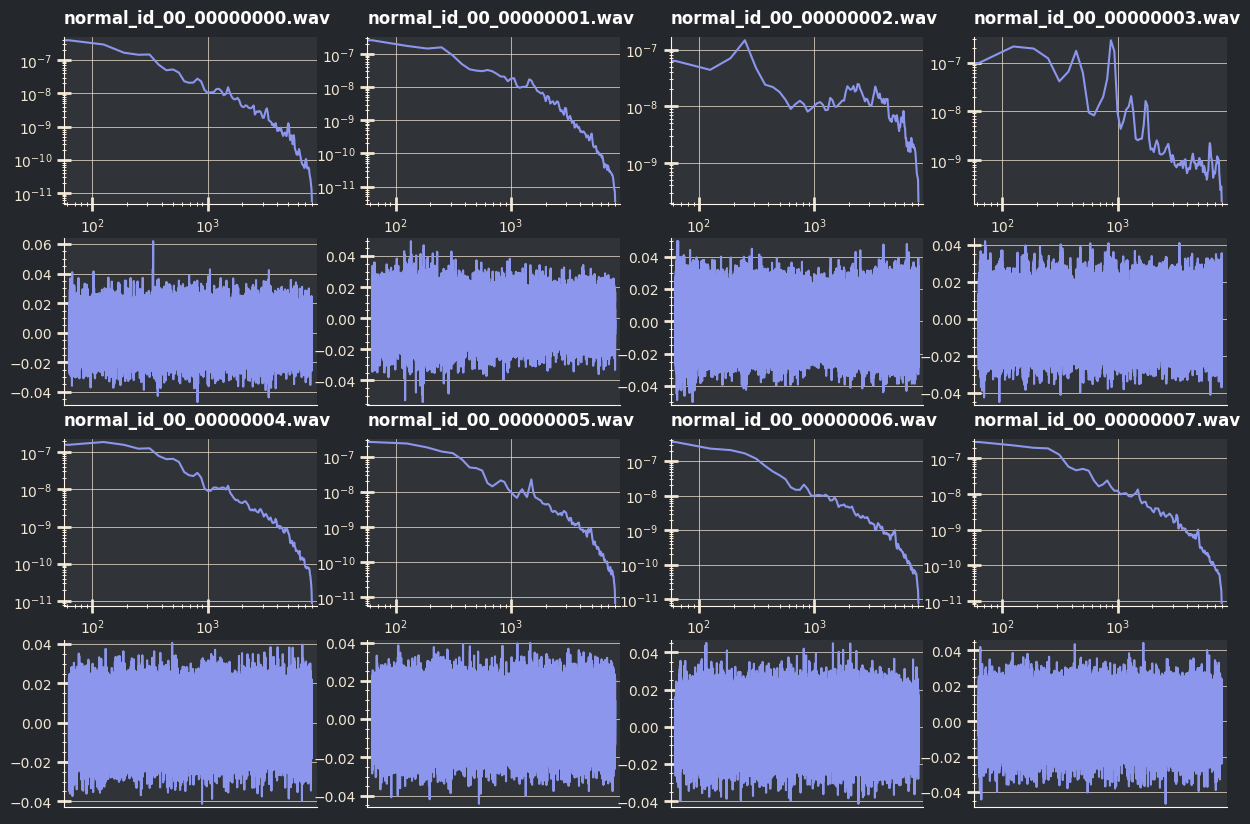

=== Machine type [slider], test set ===


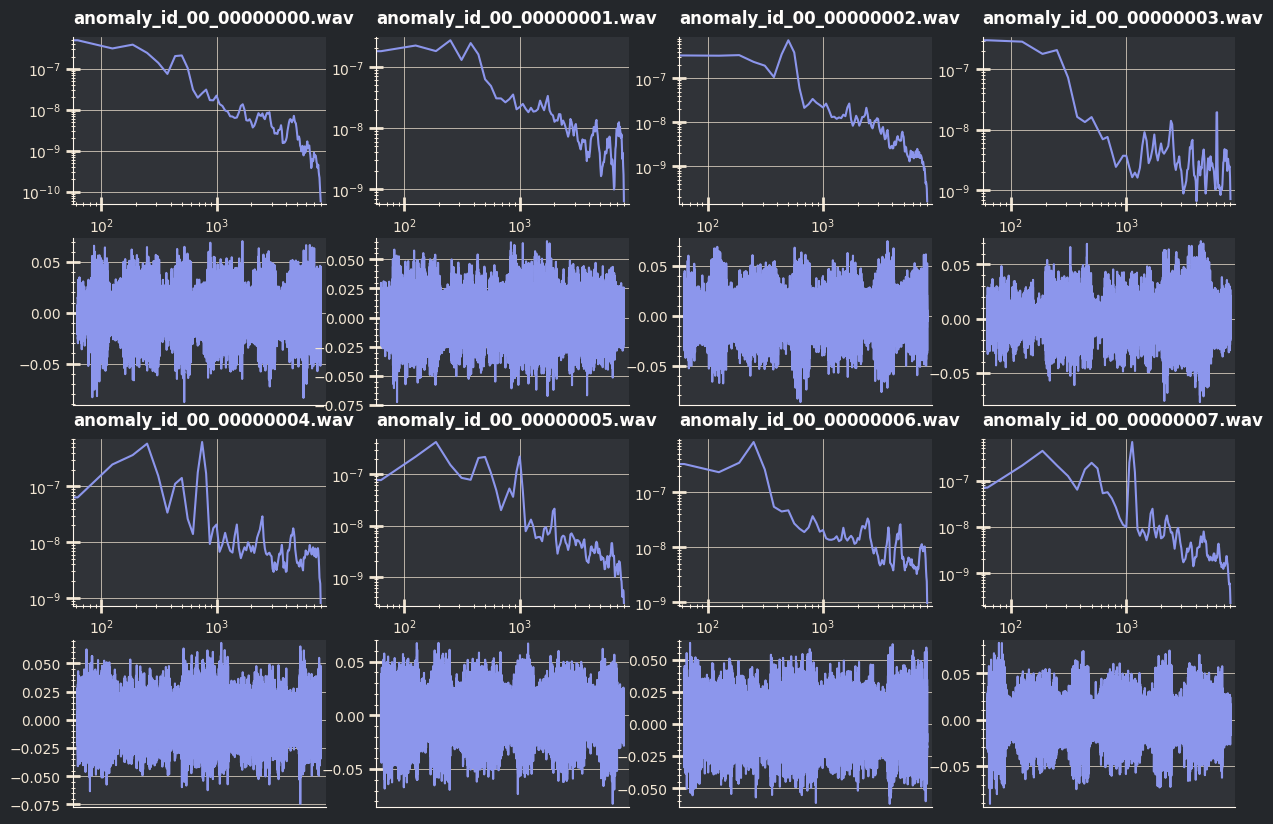

In [118]:
load_theme("umbra_dark").apply()

def get_wave_detail(filename):
    wav, sampling_rate = file_load(filename)

    n_fft = sampling_rate
    half = len(wav) // 2
    middle = wav[half - n_fft//2: half + n_fft//2]
    freq, P = signal.welch(middle, sampling_rate)

    return wav.shape, sampling_rate, wav.shape[-1]/sampling_rate, wav, P, freq

for t in types:
    for split in ['train', 'test']:
        type_df = df[(df['type'] == t) & (df['split'] == split)].reset_index()
        R = 4
        fig, ax = plt.subplots(R, 4, figsize=(15, 5 * R // 2))
        print(f'=== Machine type [{t}], {split} set ===')
        for i in range(R * 4):
            file_index = i % 4 + ((i // 8) * 4)
            file_path = Path(type_df['file'][file_index])
            shape, sr, sec, wav, P, freq = get_wave_detail(file_path)
            assert int(sr) == 16000, f'{type(sr)} {sr}'
            if (i % 8) < 4:
                ax[i // 4, i % 4].set_title(file_path.name)
                ax[i // 4, i % 4].plot(freq, P)
                ax[i // 4, i % 4].set_xscale('log')
                ax[i // 4, i % 4].set_yscale('log')
            else:
                ax[i // 4, i % 4].plot(wav)
                ax[i // 4, i % 4].get_xaxis().set_ticks([])
        plt.show()

=== Machine type [slider], train set ===


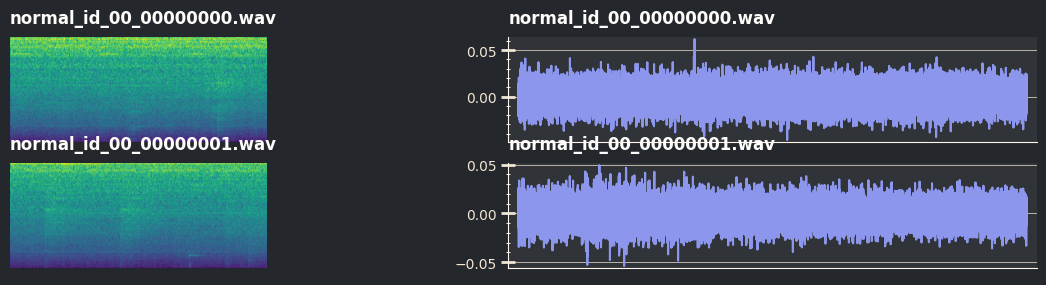

=== Machine type [slider], test set ===


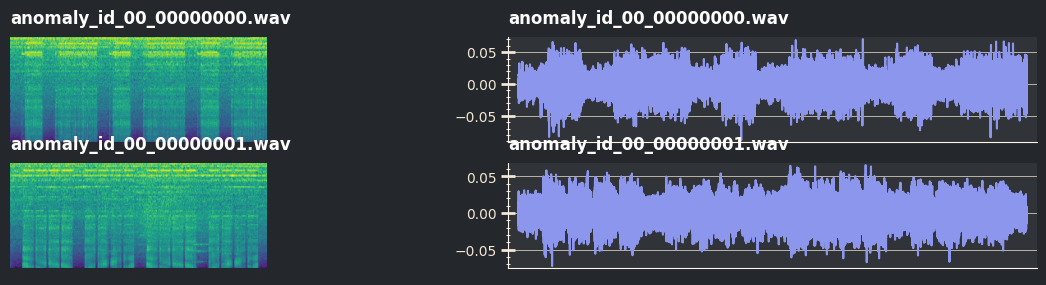

In [117]:
from aquarel import load_theme

load_theme("umbra_dark").apply()

def get_log_mel_spectrogram(filename, n_mels=128,
                             n_fft=1024,
                             hop_length=512,
                             power=2.0):
    wav, sampling_rate = com.file_load(filename)
    mel_spectrogram = librosa.feature.melspectrogram(y=wav,
                                                     sr=sampling_rate,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)
    log_mel_spectrogram = 20.0 / power * np.log10(mel_spectrogram + sys.float_info.epsilon)
    return log_mel_spectrogram, wav

for t in types:
    for split in ['train', 'test']:
        type_df = df[(df['type'] == t) & (df['split'] == split)].reset_index()
        R = 2
        fig, ax = plt.subplots(R, 2, figsize=(15, 1.5 * R))
        print(f'=== Machine type [{t}], {split} set ===')
        for i in range(R * 2):
            file_index = i // 2
            file_path = Path(type_df['file'][file_index])
            mels, wav = get_log_mel_spectrogram(file_path)
            if i % 2 == 0:
                ax[i // 2, i % 2].set_title(file_path.name)
                ax[i // 2, i % 2].imshow(mels)
                ax[i // 2, i % 2].axis('off')
            else:
                ax[i // 2, i % 2].set_title(file_path.name)
                ax[i // 2, i % 2].plot(wav)
                ax[i // 2, i % 2].get_xaxis().set_ticks([])
        plt.show()


=== Machine type [slider], train set ===


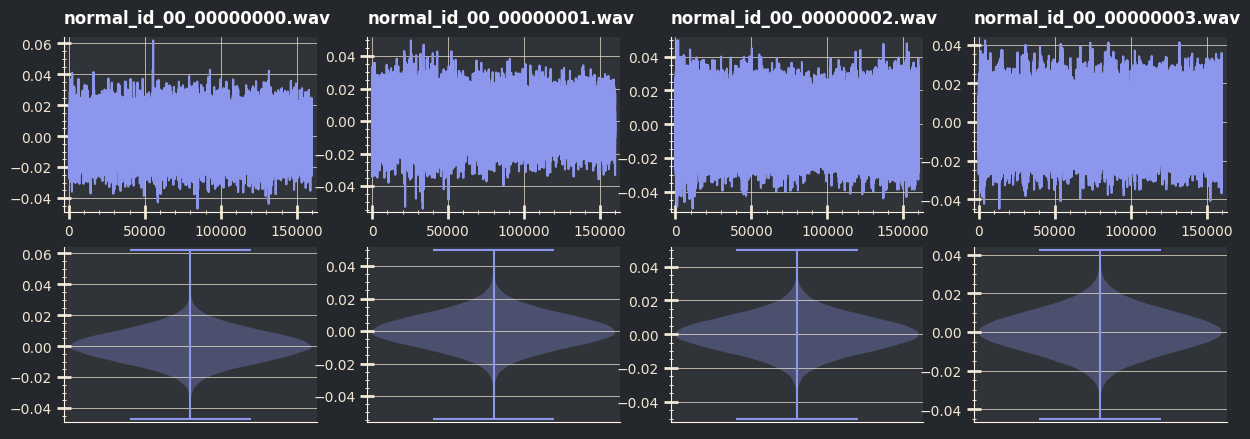

=== Machine type [slider], test set ===


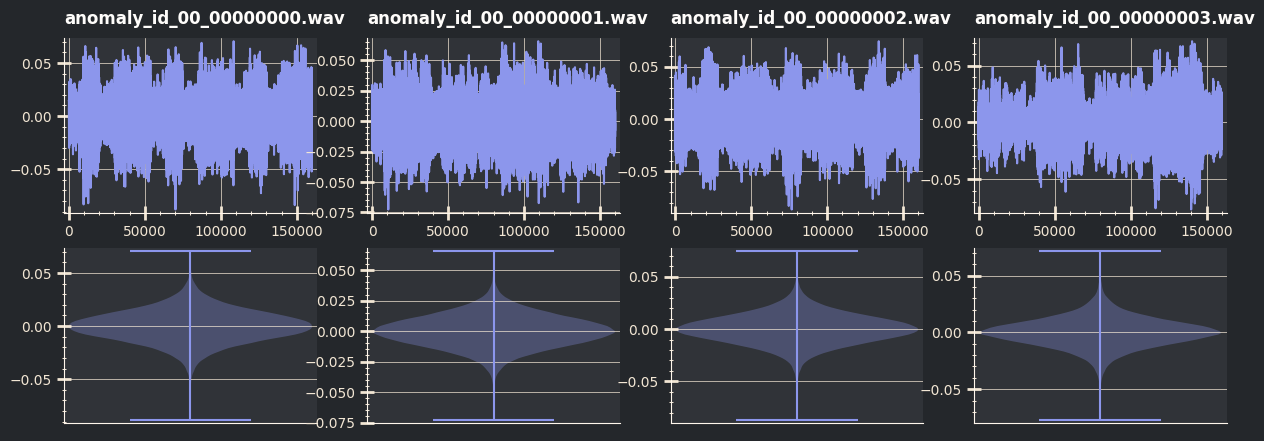

In [116]:


load_theme("umbra_dark").apply()

for t in types:
    for split in ['train', 'test']:
        type_df = df[(df['type'] == t) & (df['split'] == split)].reset_index()
        R = 2
        fig, ax = plt.subplots(R, 4, figsize=(15, 5 * R // 2))
        print(f'=== Machine type [{t}], {split} set ===')
        for i in range(R * 4):
            file_index = i % 4 + ((i // 8) * 4)
            file_path = Path(type_df['file'][file_index])
            mels, wav = get_log_mel_spectrogram(file_path)

            if (i % 8) < 4:
                ax[i // 4, i % 4].set_title(file_path.name)
                ax[i // 4, i % 4].plot(wav)
            else:
                ax[i // 4, i % 4].violinplot(wav.T)
                ax[i // 4, i % 4].get_xaxis().set_visible(False)
        plt.show()


In [131]:
from aquarel import load_theme

def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]  # Sélectionne les colonnes avec entre 1 et 50 valeurs uniques
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow  # Utilisation de la division entière pour déterminer le nombre de lignes de graphiques
    
    theme = load_theme("arctic_light")
    theme.apply()

    plt.figure(num=None, figsize=(6 * nGraphPerRow, 8 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(int(nGraphRow), int(nGraphPerRow), int(i + 1))
        columnDf = df.iloc[:, i]
        if not np.issubdtype(type(columnDf.iloc[0]), np.number):
            valueCounts = columnDf.value_counts()
            plt.pie(valueCounts, labels=valueCounts.index, autopct='%1.1f%%', startangle=140)
        else:
            columnDf.hist()
        plt.ylabel('')
        plt.title(f'{columnNames[i]} (column {i})')
    
    theme.apply_transforms()
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()




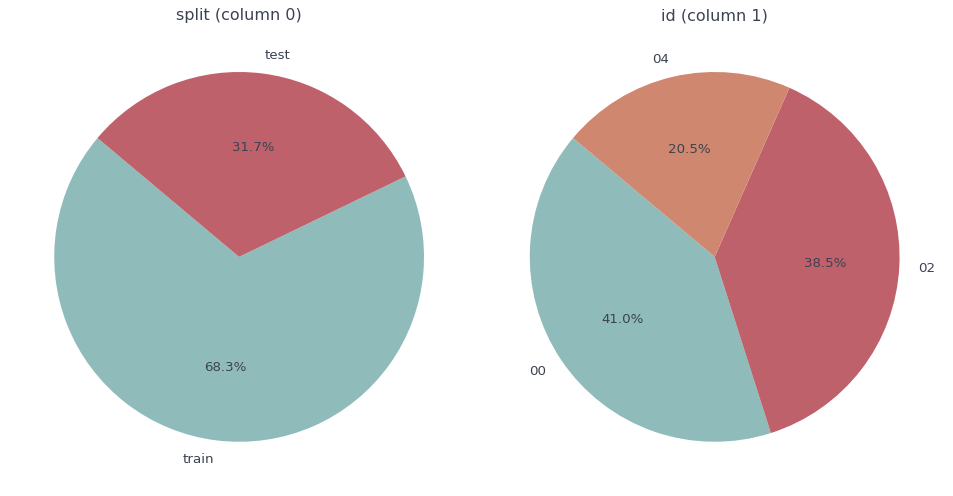

In [132]:
plotPerColumnDistribution(df, nGraphShown=10, nGraphPerRow=3)

The raw audio file is time-seris data which indicates the amplitude of the sound over time (right figures). 

However, deep learning models rarely take this raw audio directly as input, the common practice is to convert the audio into a spectrogram (left figures). The spectrogram is a concise ‘snapshot’ of an audio wave and since it is an image, it is well suited to being input to CNN-based architectures developed for handling images. If you want to understand the audio spectrogram, this Audio Deep Learning [series](https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504) is very useful. In this notebook, we use the spectrogram as input.

## Preprocessing

In [67]:
class VAE(nn.Module):
    """Mostly borrowed from PyTorch example.
    Thanks to https://github.com/pytorch/examples/blob/master/vae/main.py
    """

    def __init__(self, device, x_dim=640, h_dim=400, z_dim=20):
        super().__init__()
        self.x_dim = x_dim

        self.fc11 = nn.Linear(x_dim, h_dim)
        self.bn1 = nn.BatchNorm1d(h_dim)
        self.fc12 = nn.Linear(h_dim, h_dim)
        self.bn2 = nn.BatchNorm1d(h_dim)

        # self.fc13 = nn.Linear(h_dim, h_dim) #EXTRA
        # self.fc14 = nn.Linear(h_dim, h_dim) #EXTRA
        
        self.fc21 = nn.Linear(h_dim, z_dim)
        self.bn3 = nn.BatchNorm1d(z_dim)
        
        self.fc22 = nn.Linear(h_dim, z_dim)
        self.bn4 = nn.BatchNorm1d(z_dim)
        
        self.fc31 = nn.Linear(z_dim, h_dim)
        self.bn5 = nn.BatchNorm1d(h_dim)
        
        self.fc32 = nn.Linear(h_dim, h_dim)
        self.bn6 = nn.BatchNorm1d(h_dim)

        # self.fc33 = nn.Linear(h_dim, h_dim) #EXTRA
        # self.fc34 = nn.Linear(h_dim, h_dim) #EXTRA

        self.fc4 = nn.Linear(h_dim, x_dim)


    def encode(self, x):
        x = self.bn1(self.fc11(x))
        x = F.relu(x)
        x = self.bn2(self.fc12(x))                
        x = F.relu(x)
        
#         x = F.relu(self.fc13(x))  #EXTRA
#         x = F.relu(self.fc14(x)) #EXTRA

        return self.fc21(x), self.fc22(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = self.bn5(self.fc31(z))
        h = F.relu(h)
        h = self.bn6(self.fc32(h))
        h = F.relu(h)
        
#         h = F.relu(self.fc33(h)) #EXTRA
#         h = F.relu(self.fc34(h)) #EXTRA
        
        return torch.sigmoid(self.fc4(h))

    def forward_all(self, x):
        mu, logvar = self.encode(x.view(-1, self.x_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), z, mu, logvar

    def forward(self, x):
        yhat, _, _, _ = self.forward_all(x)
        return yhat


def VAE_loss_function(recon_x, x, mu, logvar, reconst_loss='mse', a_RECONST=1., a_KLD=1., x_dim=640):
    """Loss function for VAE which consists of reconstruction and KL divergence losses.
    Thanks to https://github.com/pytorch/examples/blob/master/vae/main.py

    You can also balance weights for each loss, just to see what if KLD loss is stronger, etc.

    Args:
        reconst_loss: Reconstruction loss calculation: 'mse' or 'bce'
        a_RECONST: Weight for reconstruction loss.
        a_KLD: Weight for KLD loss.
    """

    func = (F.mse_loss if reconst_loss == 'mse'
            else F.binary_cross_entropy if reconst_loss == 'bce'
            else 'Unknown reconst_loss')
    RECONST = func(recon_x, x.view(-1, x_dim), reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return RECONST*a_RECONST + KLD*a_KLD

In [73]:
params = {
# input directory
"dev_directory" : "../input/eurecom-aml-2022-challenge-2/dev_data/dev_data",
"eval_directory" : "../input/eurecom-aml-2022-challenge-2/eval_data/eval_data",
"model_directory": "./model",
"result_directory": "./result",
"result_file": "result.csv",
"max_fpr" : 0.1,
"mode" : True, # mode=True for development dataset, mode=False for evaluation dataset

# preprocessing for mel-spectrogram
"feature": {
"n_mels": 128,
"frames" : 5,
"n_fft": 1024,
"hop_length": 512,
"power": 2.0},

# training
"fit":{
"lr": 0.001, #0.001
"b1": 0.9, #0.9
"b2": 0.999, #0.999
"weight_decay": 0.0 ,#0.0
"epochs" : 10, #100
"batch_size" : 512, #1000
"shuffle" : True,
"validation_split" : 0.1,
"verbose" : 1},
    
# model architecture
"VAE":{
"x_dim": 640,
"h_dim": 400,
"z_dim": 20}
    
}
params = EasyDict(params)

# create working directory
ensure_folder(params.model_directory)

# test directories
dirs = com.select_dirs(param=params, mode=params.mode)

# fix random seeds
deterministic_everything(2024, pytorch=True)

# PyTorch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2024-05-28 12:42:07,764 - INFO - load_directory <- development


In [69]:
class Task2Dataset(torch.utils.data.Dataset):
    """PyTorch dataset class for task2. Caching to a file supported.

    Args:
        n_mels, frames, n_fft, hop_length, power, transform: Audio conversion settings.
        normalize: Normalize data value range from [-90, 24] to [0, 1] for VAE, False by default.
        cache_to: Cache filename or None by default, use this for your iterative development.
    """

    def __init__(self, files, n_mels, frames, n_fft, hop_length, power, transform,
                 normalize=False, cache_to=None):
        self.transform = transform
        self.files = files
        self.n_mels, self.frames, self.n_fft = n_mels, frames, n_fft
        self.hop_length, self.power = hop_length, power
        # load cache or convert all the data for the first time
        if cache_to is not None and Path(cache_to).exists():
            com.logger.info(f'Loading cached {Path(cache_to).name}')
            self.X = np.load(cache_to)
        else:
            self.X = com.list_to_vector_array(self.files,
                             n_mels=self.n_mels,
                             frames=self.frames,
                             n_fft=self.n_fft,
                             hop_length=self.hop_length,
                             power=self.power)
            if cache_to is not None:
                np.save(cache_to, self.X)

        if normalize:
            self.X = normalize_0to1(self.X)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        x = self.X[index]
        x = self.transform(x)
        return x, x


# VAE Training class
class Task2VAELightning(pl.LightningModule):
    """Task2 PyTorch Lightning class, for training only."""

    def __init__(self, device, model, params, files, normalize=False):
        super().__init__()
        self.params = params
        self.normalize = normalize
        self.model = model
        self.mseloss = torch.nn.MSELoss()
        # split data files
        if files is not None:
            n_val = int(params.fit.validation_split * len(files))
            self.val_files = random.sample(files, n_val)
            self.train_files = [f for f in files if f not in self.val_files]

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat, z, mu, logvar = self.model.forward_all(x)
        loss = VAE_loss_function(recon_x=y_hat, x=x, mu=mu, logvar=logvar,
                                 reconst_loss='mse',
                                 a_RECONST=1.,
                                 a_KLD=.01)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        return {'val_loss': self.mseloss(y_hat, y)}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.params.fit.lr,
                                betas=(self.params.fit.b1, self.params.fit.b2),
                                weight_decay=self.params.fit.weight_decay)

    def _get_dl(self, for_what):
        files = self.train_files if for_what == 'train' else self.val_files
        cache_file = f'{self.params.model_directory}/__cache_{str(files[0]).split("/")[-3]}_{for_what}.npy'
        ds = Task2Dataset(files,
                          n_mels=self.params.feature.n_mels,
                          frames=self.params.feature.frames,
                          n_fft=self.params.feature.n_fft,
                          hop_length=self.params.feature.hop_length,
                          power=self.params.feature.power,
                          transform=ToTensor1ch(device=device),
                          normalize=self.normalize,
                          cache_to=cache_file)
        return torch.utils.data.DataLoader(ds, batch_size=self.params.fit.batch_size,
                          shuffle=(self.params.fit.shuffle if for_what == 'train' else False))

    def train_dataloader(self):
        return self._get_dl('train')

    def val_dataloader(self):
        return self._get_dl('val')

In [74]:
# train models

def train():
    for target_dir in dirs:
        target = str(target_dir).split('/')[-1]
        print(f'==== Start training [{target}] with {torch.cuda.device_count()} GPU(s). ====')

        files = com.file_list_generator(target_dir)

        model = VAE(device, x_dim=params.VAE.x_dim, h_dim=params.VAE.h_dim, z_dim=params.VAE.z_dim).to(device)
        summary(device, model)
        task2 = Task2VAELightning(device, model, params, files, normalize=True)
        trainer = pl.Trainer(max_epochs=params.fit.epochs,
                             gpus=torch.cuda.device_count())
        trainer.fit(task2)

        model_file = f'{params.model_directory}/model_{target}.pth'
        torch.save(task2.model.state_dict(), model_file)
        print(f'saved {model_file}.\n')
        
train()

2024-05-28 12:42:30,217 - INFO - target_dir : dev_data/slider
2024-05-28 12:42:30,230 - INFO - # of training samples : 2370


==== Start training [slider] with 1 GPU(s). ====
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]         256,400
       BatchNorm1d-2                  [-1, 400]             800
            Linear-3                  [-1, 400]         160,400
       BatchNorm1d-4                  [-1, 400]             800
            Linear-5                   [-1, 20]           8,020
            Linear-6                   [-1, 20]           8,020
            Linear-7                  [-1, 400]           8,400
       BatchNorm1d-8                  [-1, 400]             800
            Linear-9                  [-1, 400]         160,400
      BatchNorm1d-10                  [-1, 400]             800
           Linear-11                  [-1, 640]         256,640
Total params: 861,480
Trainable params: 861,480
Non-trainable params: 0
----------------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

2024-05-28 12:42:30,306 - INFO - Loading cached __cache_slider_val.npy


calc...:   0%|          | 0/2133 [00:00<?, ?it/s]

2024-05-28 12:42:30,842 - INFO - Creating data for 2133 files: size=659097, shape=(640,)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([17, 1, 640])) that is different to the input size (torch.Size([17, 640])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

saved ./model/model_slider.pth.



In [75]:
def test():
    # make output result directory
    os.makedirs(params.result_directory, exist_ok=True)

    # load base directory
    dirs = com.select_dirs(param=params, mode=params.mode)

    # initialize lines in csv for AUC and pAUC
    csv_lines = []

    # PyTorch version specific...
    to_tensor = pytorch_common.ToTensor1ch()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # loop of the base directory
    for idx, target_dir in enumerate(dirs):
        print("\n===========================")
        print("[{idx}/{total}] {dirname}".format(dirname=target_dir, idx=idx+1, total=len(dirs)))
        machine_type = os.path.split(target_dir)[1]

        print("============== MODEL LOAD ==============")
        # set model path
        model_file = "{model}/model_{machine_type}.pth".format(model=params.model_directory,
                                                               machine_type=machine_type)

        # load model file
        if not os.path.exists(model_file):
            com.logger.error("{} model not found ".format(machine_type))
            sys.exit(-1)
        com.logger.info("loading model: {}".format(model_file))
        model = VAE(device, x_dim=params.VAE.x_dim, h_dim=params.VAE.h_dim, z_dim=params.VAE.z_dim).to(device)
        pytorch_common.load_weights(model, model_file)
        pytorch_common.summary(device, model)
        model.eval()

        if params.mode:
            # results by type
            csv_lines.append([machine_type])
            csv_lines.append(["id", "AUC", "pAUC"])
            performance = []

        machine_id_list = get_machine_id_list_for_test(target_dir)

        for id_str in machine_id_list:
            # load test file
            test_files, y_true = test_file_list_generator(target_dir, id_str, mode=params.mode)

            # setup anomaly score file path
            anomaly_score_csv = "{result}/anomaly_score_{machine_type}_{id_str}.csv".format(
                                                                                     result=params.result_directory,
                                                                                     machine_type=machine_type,
                                                                                     id_str=id_str)
            anomaly_score_list = []

            print("\n============== BEGIN TEST FOR A MACHINE ID ==============")
            y_pred = [0. for k in test_files]
            for file_idx, file_path in tqdm(enumerate(test_files), total=len(test_files)):
                try:
                    data = com.file_to_vector_array(file_path,
                                                    n_mels=params.feature.n_mels,
                                                    frames=params.feature.frames,
                                                    n_fft=params.feature.n_fft,
                                                    hop_length=params.feature.hop_length,
                                                    power=params.feature.power)
                    data = pytorch_common.normalize_0to1(data)
                    with torch.no_grad():
                        yhat = model(to_tensor(data)).cpu().detach().numpy().reshape(data.shape)
                        errors = numpy.mean(numpy.square(data - yhat), axis=1)
                    y_pred[file_idx] = numpy.mean(errors)
                    anomaly_score_list.append([os.path.basename(file_path), y_pred[file_idx]])
                except:
                    com.logger.error("file broken!!: {}".format(file_path))
                    sys.exit(-1)

            # save anomaly score
            save_csv(save_file_path=anomaly_score_csv, save_data=anomaly_score_list)
            com.logger.info("anomaly score result ->  {}".format(anomaly_score_csv))

            if params.mode:
                # append AUC and pAUC to lists
                auc = metrics.roc_auc_score(y_true, y_pred)
                p_auc = metrics.roc_auc_score(y_true, y_pred, max_fpr=params.max_fpr)
                csv_lines.append([id_str.split("_", 1)[1], auc, p_auc])
                performance.append([auc, p_auc])
                com.logger.info("AUC : {}".format(auc))
                com.logger.info("pAUC : {}".format(p_auc))

            print("\n============ END OF TEST FOR A MACHINE ID ============")

        if params.mode:
            # calculate averages for AUCs and pAUCs
            averaged_performance = numpy.mean(numpy.array(performance, dtype=float), axis=0)
            csv_lines.append(["Average"] + list(averaged_performance))
            csv_lines.append([])

    if params.mode:
        # output results
        result_path = "{result}/{file_name}".format(result=params.result_directory, file_name=params.result_file)
        com.logger.info("AUC and pAUC results -> {}".format(result_path))
        save_csv(save_file_path=result_path, save_data=csv_lines)

test()

2024-05-28 12:50:51,502 - INFO - load_directory <- development
2024-05-28 12:50:51,507 - INFO - loading model: ./model/model_slider.pth
2024-05-28 12:50:51,538 - INFO - target_dir : /kaggle/input/eurecom-aml-2022-challenge-2/dev_data/dev_data/slider_id_00
2024-05-28 12:50:51,546 - INFO - test_file  num : 456



[1/1] /kaggle/input/eurecom-aml-2022-challenge-2/dev_data/dev_data/slider
============== MODEL LOAD ==============
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]         256,400
       BatchNorm1d-2                  [-1, 400]             800
            Linear-3                  [-1, 400]         160,400
       BatchNorm1d-4                  [-1, 400]             800
            Linear-5                   [-1, 20]           8,020
            Linear-6                   [-1, 20]           8,020
            Linear-7                  [-1, 400]           8,400
       BatchNorm1d-8                  [-1, 400]             800
            Linear-9                  [-1, 400]         160,400
      BatchNorm1d-10                  [-1, 400]             800
           Linear-11                  [-1, 640]         256,640
Total params: 861,480
Trainable params: 861,480
Non

100%|██████████| 456/456 [00:16<00:00, 28.15it/s]
2024-05-28 12:51:07,755 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_00.csv
2024-05-28 12:51:07,761 - INFO - AUC : 0.9469943820224719
2024-05-28 12:51:07,763 - INFO - pAUC : 0.7529568302779421
2024-05-28 12:51:07,766 - INFO - target_dir : /kaggle/input/eurecom-aml-2022-challenge-2/dev_data/dev_data/slider_id_02
2024-05-28 12:51:07,784 - INFO - test_file  num : 367



============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


100%|██████████| 367/367 [00:12<00:00, 28.41it/s]
2024-05-28 12:51:20,720 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_02.csv
2024-05-28 12:51:20,729 - INFO - AUC : 0.739625468164794
2024-05-28 12:51:20,733 - INFO - pAUC : 0.6006307904592944
2024-05-28 12:51:20,738 - INFO - target_dir : /kaggle/input/eurecom-aml-2022-challenge-2/dev_data/dev_data/slider_id_04
2024-05-28 12:51:20,757 - INFO - test_file  num : 278



============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


100%|██████████| 278/278 [00:10<00:00, 27.56it/s]
2024-05-28 12:51:30,859 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_04.csv
2024-05-28 12:51:30,865 - INFO - AUC : 0.8927528089887641
2024-05-28 12:51:30,866 - INFO - pAUC : 0.6262566528681254
2024-05-28 12:51:30,867 - INFO - AUC and pAUC results -> ./result/result.csv



============ END OF TEST FOR A MACHINE ID ============


In [76]:
def upto_6digits(cell):
    if not cell[0].isdigit(): return cell
    return f'{float(cell):.6f}'

if params.mode:
    with open('./result/result.csv') as f:
        for l in f.readlines():
            l = l.strip() #replace('\n', '')
            if ',' not in l:
                print(l)
                continue
            ls = l.split(',')
            print(f'{ls[0]}\t\t{upto_6digits(ls[1])}\t\t{upto_6digits(ls[2])}')

slider
id		AUC		pAUC
00		0.946994		0.752957
02		0.739625		0.600631
04		0.892753		0.626257
Average		0.859791		0.659948

